# $\Psi$ Method - Weibull

The method updates the posterior probability distribution across the sampled space of the psychometric functions based on Bayes' rule (Hall, 1968; Watson & Pelli, 1983). The space of the psychometric functions is two-dimensional (Watson and Pelli, 1983; King-Smith & Rose, 1997). Evaluation of the psychometric function is based on computing the mean of the posterior probability distribution (Emerson, 1986; King-Smith et al., 1994). The termination rule is based on the number of trials, as the most practical option (Watson & Pelli, 1983; King-Smith et al., 1994). The placement of each new trial is based on one-step ahead minimum search (King-Smith, 1984) of the expected entropy cost function (Pelli, 1987b).

https://christophertyler.org/CWTyler/Pubtopics/PsiMethod/Psi.html

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def WEIBULL(x,th,b,g=0.5,d=0.02):
    
    # x   stimulus intensity
    # th  threshold
    # b   slope
    # g   guess rate
    # d   lapse rate
    
    w = 1-d - (1-g-d)*np.exp(-(x/th)**b)
    
    return w

def SIMULATE_OBSERVER(x_next):
    th = 0.8
    b = 1
    p_next_true = WEIBULL(x_next,th,b)
    response = np.random.choice([0, 1], p=[1-p_next_true, p_next_true])

## A) Initialize lookup table $p(r_x|\theta)$ $\ \ \forall$ $\theta,x,r_x \ \ \ $and flat prior $p(\theta)$

In [4]:
nStim = 100
nVal = 20
nPar = 2     # th,b

# All stimulus intensities (i.e. contrast values)
x_space = np.logspace(-3,0,nStim)

# All possible values of parameters (th,b)...
theta_space = np.zeros((nVal,nPar))
theta_space[:,0] = np.logspace(-3,0,nVal)       # th
theta_space[:,1] = np.logspace(0,0.66,nVal)     # b

# ...and combinations (param vectors)
nVec = nVal**nPar
theta_vector = np.zeros((nVec,nPar))
for p in range(nPar):
    theta_vector[:,p] = np.tile(np.repeat(theta_space[:,p],nVal**(nPar-p-1)),nVal**p)

# Probability of response (success) to stimulus x, given parameters (theta)... p(failure) = 1-p(success)
psi = np.zeros((nStim,nVec))
for i,[th,b] in enumerate(theta_vector):
    psi[:,i] = WEIBULL(x_space,th,b)
    
prior = np.ones(nVec)/nVec

# List of posterior update and expectd entropy
POSTERIOR = []
ENTROPY = []

## B) For each trial:

### 1) Compute $p_t(r_x) = \sum\limits_{\theta}p_t(\theta)*p(r_x|\theta)$ $\ \ \forall$ $x,r_x$

### 2) Compute posterior $p_t(\theta|r_x) = \frac{p_t(\theta)*p(r_x|\theta)}{p_t(r_x)}$ $\ \ \forall$ $\theta,x,r_x$

### 3) Compute posterior entropy $H_t(\Theta|r_x) = -\sum\limits_{\theta}p_t(\theta|r_x)*log \ p_t(\theta|r_x) $ $\ \ \forall$ $x,r_x$

### 4) Compute expected posterior entropy $H_t(\Theta|R_x) = \sum\limits_{r_x}p_t(r_x)*H(\Theta|r_x) $ $\ \ \forall$ $x$

### 5) Find $x_{next} = arg\min\limits_{x} H_t(\Theta|R_x) $

### 6) Show next stimulus and collect response $r^{t}_{x_{next}}$

### 7) Update prior distribution $p_{t+1}(\theta) = p_{t}(\theta|r^{t}_{x_{next}})$ $\ \ \forall$ $\theta$

In [7]:
nTrial = 20

for t in range(nTrial):
    
    # 1)
    p_success = np.matmul(psi,prior)
    p_failure = 1-p_success
    
    # 2)
    posterior_success = np.zeros((nStim,nVec))
    posterior_failure = np.zeros((nStim,nVec))
    for i in range(nStim):
        for j in range(nVec):
            posterior_success[i,j] = psi[i,j]*prior[j]/p_success[i]
            posterior_failure[i,j] = (1-psi[i,j])*prior[j]/p_failure[i]

    # 3)
    post_entropy_success = np.zeros(nStim)
    post_entropy_failure = np.zeros(nStim) 
    for i in range(nStim):
        post_entropy_success[i] = -sum(posterior_success[i,:]*np.log(posterior_success[i,:]))
        post_entropy_failure[i] = -sum(posterior_failure[i,:]*np.log(posterior_failure[i,:]))
        
    # 4)
    expected_post_entropy = p_success*post_entropy_success + p_failure*post_entropy_failure
    
    # 5)
    ind_next = np.argmin(expected_post_entropy)
    x_next = x_space[ind_next]
    
    # 6)
    response = SIMULATE_OBSERVER(x_next)
    
    # 7)
    if response:
        prior = psi[ind_next,:]*prior/p_success[ind_next]
    else:
        prior = (1-psi[ind_next,:])*prior/p_failure[ind_next]
        
    '''
    plt.subplot(121)
    plt.plot(p_success,label='p(success)')
    plt.plot(p_failure,label='p(failure)')
    plt.legend()
    plt.subplot(122)
    plt.plot(post_entropy_success,label='success')
    plt.plot(post_entropy_failure,label='failure')
    plt.plot(expected_post_entropy,label='expected ')
    plt.legend()
    plt.title('posterior entropy')
    plt.show()
    
    p_theta = np.zeros((nVal,nPar))
    for i in range(nVal):
        for p in range(nPar):
            ind = np.arange(nVec/nVal**(nPar-p-1))
            tmp = np.repeat(ind%nVal,nVal**(nPar-p-1))
            x = np.argwhere(tmp==i)
            p_theta[i,p] = sum(prior[x])

    plt.subplot(121)
    plt.plot(theta_space[:,0],p_theta[:,0])
    plt.title('prior update (th)')
    plt.subplot(122)
    plt.plot(theta_space[:,1],p_theta[:,1])
    plt.title('prior update (b)')
    plt.show()
    
    a=input()
    '''

[[3.94961180e-51 3.94961180e-51 3.94961180e-51 ... 1.20835621e-01
  2.55417827e-01 5.22958992e-01]
 [4.01013043e-51 4.01516035e-51 4.02060653e-51 ... 1.20835621e-01
  2.55417827e-01 5.22958992e-01]
 [4.07034296e-51 4.08031873e-51 4.09110380e-51 ... 1.20835621e-01
  2.55417827e-01 5.22958992e-01]
 ...
 [3.42530491e-51 3.42530491e-51 3.42530491e-51 ... 1.22240246e-01
  2.55847920e-01 5.18325359e-01]
 [3.20571657e-51 3.20571657e-51 3.20571657e-51 ... 1.21566437e-01
  2.55653027e-01 5.20553421e-01]
 [2.99823150e-51 2.99823150e-51 2.99823150e-51 ... 1.20833743e-01
  2.55413858e-01 5.22950865e-01]]
[[4.01826135e-52 4.01826135e-52 4.01826135e-52 ... 1.20833135e-01
  2.55412571e-01 5.22948231e-01]
 [4.07983345e-52 4.08495094e-52 4.09049192e-52 ... 1.20833135e-01
  2.55412571e-01 5.22948230e-01]
 [4.14109413e-52 4.15124355e-52 4.16221636e-52 ... 1.20833135e-01
  2.55412571e-01 5.22948230e-01]
 ...
 [3.48485679e-52 3.48485679e-52 3.48485679e-52 ... 1.22238811e-01
  2.55844813e-01 5.18318838e-01]

[[5.20387643e-67 5.20387643e-67 5.20387643e-67 ... 1.20832526e-01
  2.55411285e-01 5.22945597e-01]
 [5.28361629e-67 5.29024377e-67 5.29741970e-67 ... 1.20832526e-01
  2.55411285e-01 5.22945597e-01]
 [5.36295285e-67 5.37609700e-67 5.39030750e-67 ... 1.20832526e-01
  2.55411285e-01 5.22945597e-01]
 ...
 [4.51309218e-67 4.51309218e-67 4.51309218e-67 ... 1.22238460e-01
  2.55844053e-01 5.18317242e-01]
 [4.22376811e-67 4.22376811e-67 4.22376811e-67 ... 1.21564927e-01
  2.55649784e-01 5.20546670e-01]
 [3.95039101e-67 3.95039101e-67 3.95039101e-67 ... 1.20832527e-01
  2.55411285e-01 5.22945599e-01]]
[[5.29435345e-68 5.29435345e-68 5.29435345e-68 ... 1.20832526e-01
  2.55411285e-01 5.22945597e-01]
 [5.37547970e-68 5.38222241e-68 5.38952310e-68 ... 1.20832526e-01
  2.55411285e-01 5.22945597e-01]
 [5.45619564e-68 5.46956832e-68 5.48402589e-68 ... 1.20832526e-01
  2.55411285e-01 5.22945597e-01]
 ...
 [4.59155889e-68 4.59155889e-68 4.59155889e-68 ... 1.22238460e-01
  2.55844053e-01 5.18317242e-01]

## C) Estimate parameters

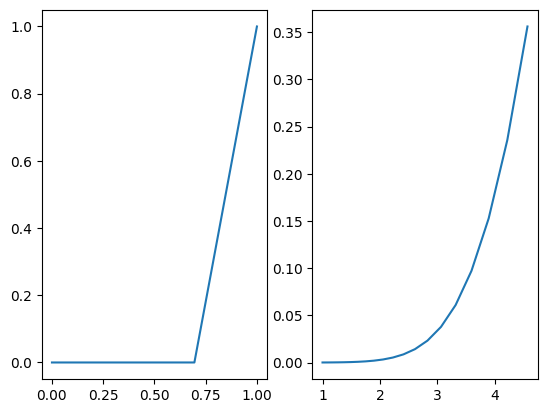

th estimated = 1.00
b estimated = 4.03


In [4]:
p_theta = np.zeros((nVal,nPar))

for i in range(nVal):
        for p in range(nPar):
            ind = np.arange(nVec/nVal**(nPar-p-1))
            tmp = np.repeat(ind%nVal,nVal**(nPar-p-1))
            x = np.argwhere(tmp==i)
            p_theta[i,p] = sum(prior[x])

plt.subplot(121)
plt.plot(theta_space[:,0],p_theta[:,0])
plt.subplot(122)
plt.plot(theta_space[:,1],p_theta[:,1])
plt.show()

th_est, b_est =  sum(theta_space[:,0]*p_theta[:,0]) , sum(theta_space[:,1]*p_theta[:,1])
print(f'th estimated = {th_est:.2f}\nb estimated = {b_est:.2f}')

## D) Plot posterior and entropy (each trial)

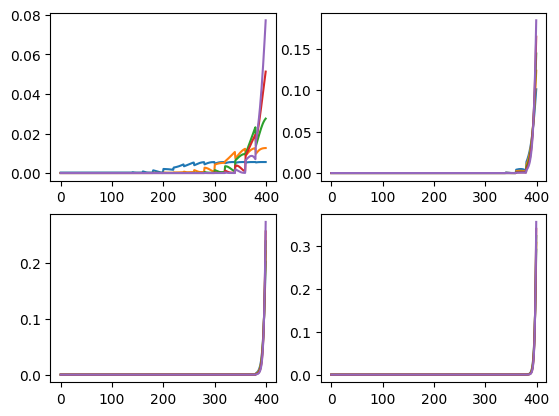

In [14]:
fig, axs = plt.subplots(2, 2)

for p in POSTERIOR[0:5]:
    axs[0, 0].plot(p)
    
for p in POSTERIOR[5:10]:
    axs[0, 1].plot(p)
    
for p in POSTERIOR[10:15]:
    axs[1, 0].plot(p)
    
for p in POSTERIOR[15:20]:
    axs[1, 1].plot(p)

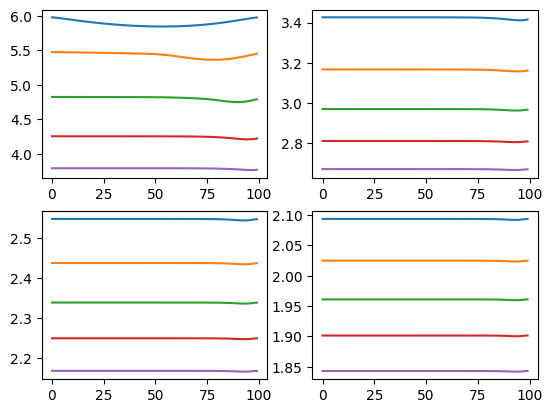

In [15]:
fig, axs = plt.subplots(2, 2)

for p in ENTROPY[0:5]:
    axs[0, 0].plot(p)
    
for p in ENTROPY[5:10]:
    axs[0, 1].plot(p)
    
for p in ENTROPY[10:15]:
    axs[1, 0].plot(p)
    
for p in ENTROPY[15:20]:
    axs[1, 1].plot(p)